# Summary of fit and evaluate experiments for simple feedforward neural networks

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

import graph_utils as graph_utils
import graph_neural_networks as graph_nn
import data_preparation_utils as data_prep
from iterative_updaters import VanillaGradientDescent, MomentumGradientDescent, NesterovMomentumGradientDescent, RMSPropGradientDescent, AdamGradientDescent
import training_and_evaluation as train_eval
import graph_nn_experiments as experiments

C:\Users\Lukasz\AppData\Local\conda\conda\envs\aind\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# this function constructs a simple feedforward neural net with the specified number of hidden layers and neurons
def simple_feedforward_neural_net(inpt, no_of_layers, no_of_neurons, activation_function):
    hidden = tf.layers.dense(inpt, no_of_neurons, activation=activation_function, kernel_initializer=tf.contrib.layers.xavier_initializer())
    for i in range(no_of_layers - 1):
        hidden = tf.layers.dense(hidden, no_of_neurons, activation=activation_function, kernel_initializer=tf.contrib.layers.xavier_initializer())
    return tf.layers.dense(hidden, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())

In [4]:
experiments_directory = "100k_feedforward_fit_and_evaluate_experiments"

def gradient_descent_set_file_name(no_of_layers, no_of_channels, activation):
    return "%s/simulation_Xy_%d_%d_%s.csv" % (experiments_directory, no_of_layers, no_of_channels, activation)

gradient_descent_set_file_name(10, 11, "relu")

'100k_feedforward_fit_and_evaluate_experiments/simulation_Xy_10_11_relu.csv'

Seems to work fine. Unfortunately, I haven't saved these file names to fit_eval_results.csv

In [5]:
df = pd.read_csv("100k_feedforward_fit_and_evaluate_experiments/fit_eval_results.csv", header=None)
df.sort_values([5])

,0,1,2,3,4,5
5,2,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.019872,0.022308
6,3,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.026668,0.023650
1,3,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.019230,0.029692
2,4,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.027142,0.031580
4,2,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.018455,0.033653
7,4,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.018923,0.037320
0,2,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.027180,0.048057
8,3,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.024013,0.074120
3,4,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.029323,0.078345


We need the original training data for scaling:

In [6]:
traffic_lights_data = pd.read_csv("100k.csv", header=None)
traffic_lights_data.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,81,14,58,108,83,60,82,61,64,94,...,28,87,73,69,25,7,77,95,5,49082
1,81,92,16,44,95,64,110,98,95,105,...,42,5,40,105,118,48,40,62,45,51223
2,75,20,66,104,20,65,80,97,2,81,...,119,115,118,64,68,46,45,43,18,51461
3,30,42,65,108,67,81,85,32,83,48,...,107,79,44,90,6,25,46,102,62,45119
4,117,20,52,40,25,36,87,78,99,70,...,92,21,34,102,37,46,11,9,66,50660


In [7]:
X, y, X_scaler, y_scaler = data_prep.scale_standard_traffic_light_data(traffic_lights_data)

C:\Users\Lukasz\AppData\Local\conda\conda\envs\aind\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
np.mean(traffic_lights_data[21])

48922.72721576669

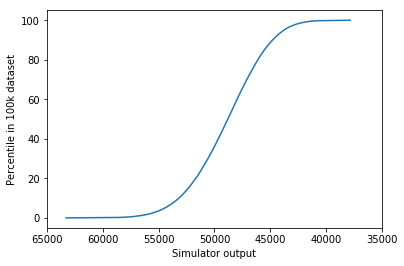

In [157]:
ps = [i / 4.0 for i in range(401)]
percentiles=-np.percentile(-traffic_lights_data[21], ps)
plt.xlim(65000.0,35000.0)
plt.xlabel("Simulator output")
plt.ylabel("Percentile in 100k dataset")
plt.plot(percentiles, ps)

Train test split:

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=831191)

This code not really used, just kept in case:

In [8]:
def load_gradient_descent_data(no_of_layers, no_of_channels, activation_name):
    data_file_name = gradient_descent_set_file_name(no_of_layers, no_of_channels, activation_name)
    data = pd.read_csv(data_file_name, header=None)
    no_of_columns = data.shape[1]
    X = data.iloc[:,0:(no_of_columns-1)]
    y = data.iloc[:,no_of_columns-1].values.reshape(-1,1)
    
    data_normalized = data.copy()
    data_normalized.iloc[:,0:(no_of_columns-1)] = X_scaler.transform(data_normalized.iloc[:,0:(no_of_columns-1)])
    data_normalized.iloc[:,no_of_columns-1] = y_scaler.transform(data_normalized.iloc[:,no_of_columns-1].values.reshape(-1,1))
    X_scaled = data_normalized.iloc[:,0:(no_of_columns-1)]
    y_scaled = data_normalized.iloc[:,no_of_columns-1]
    
    return X, y, X_scaled, y_scaled

def scale_data(X_input, y_input, X_scaler, y_scaler):
    X_input_ = X_input.copy()
    y_input_ = y_input.copy()
    X_scaled = X_scaler.transform(X_input_)
    y_scaled = y_scaler.transform(y_input_)
    return X_scaled, y_scaled
    
    
def find_lowest_avg_waiting_time(no_of_layers, no_of_channels, activation_name):
    X, y, X_scaled, y_scaled = load_gradient_descent_data(no_of_layers, no_of_channels, activation_name)
    return min(y)[0]

def assess_avg_error_below_some_target_values(target_values, 
                                              no_of_layers,
                                              no_of_neurons, 
                                              activation_name,
                                              model_file_name,
                                              X_scaler, 
                                              y_scaler):
    
    g_X, g_y, scaled_g_X, scaled_g_y = load_gradient_descent_data(no_of_layers, no_of_neurons, activation_name)
    #scaled_g_X, scaled_g_y = scale_data(g_X, g_y, X_scaler, y_scaler)
    
    if activation_name == "relu":
        activation = tf.nn.relu
    else:
        activation = tf.nn.tanh
        
    tf.reset_default_graph()
    nn_input = tf.placeholder(dtype=tf.float32, shape=[None, 21])
    targets = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    print("Constructing network with %d layers, %d neurons per layer and %s activation function" % (no_of_layers, no_of_neurons, activation_name))
    nn_output = simple_feedforward_neural_net(nn_input, no_of_layers, no_of_neurons, activation)
    
    avg_errors = []
    
    for target_value in target_values:
        
        selected_indices = np.argwhere(g_y.reshape(-1) < target_value).reshape(-1)
        
        if len(selected_indices) > 0:
            X_test = scaled_g_X.iloc[selected_indices,:]
            y_test = scaled_g_y[selected_indices]
            model_avg_error, actual_vs_predicted = train_eval.evaluate_model_on_a_dataset(model_file_name, nn_output, nn_input, X_test, y_test, y_scaler)
        else:
            model_avg_error = np.nan
            
        avg_errors.append(model_avg_error)
        
    return avg_errors

def find_maximum_relative_error(no_of_layers, no_of_neurons, activation_name, model_file_name, X_scaler, y_scaler):
    
    if activation_name == "relu":
        activation = tf.nn.relu
    else:
        activation = tf.nn.tanh
        
    tf.reset_default_graph()
    nn_input = tf.placeholder(dtype=tf.float32, shape=[None, 21])
    targets = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    print("Constructing network with %d layers, %d channels per layer and %s activation function" % (no_of_layers, no_of_channels, activation_name))
    nn_output = simple_feedforward_neural_net(nn_input, no_of_layers, no_of_neurons, activation)
    
    model_max_error = train_eval.find_model_maximum_relative_error_on_a_dataset(model_file_name, nn_output, nn_input, X_test, y_test, y_scaler)
    
    return model_max_error

def assess_error_stdev_below_some_target_values(target_values, 
                                                no_of_layers,
                                                no_of_neurons, 
                                                activation_name,
                                                model_file_name,
                                                X_scaler, 
                                                y_scaler):
    
    g_X, g_y, scaled_g_X, scaled_g_y = load_gradient_descent_data(no_of_layers, no_of_neurons, activation_name)
    #scaled_g_X, scaled_g_y = scale_data(g_X, g_y, X_scaler, y_scaler)
    
    if activation_name == "relu":
        activation = tf.nn.relu
    else:
        activation = tf.nn.tanh
        
    tf.reset_default_graph()
    nn_input = tf.placeholder(dtype=tf.float32, shape=[None, 21])
    targets = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    print("Constructing network with %d layers, %d channels per layer and %s activation function" % (no_of_layers, no_of_channels, activation_name))
    nn_output = simple_feedforward_neural_net(nn_input, no_of_layers, no_of_neurons, activation)
    
    error_stdevs = []
    
    for target_value in target_values:
        
        selected_indices = np.argwhere(g_y.reshape(-1) < target_value).reshape(-1)
        
        if len(selected_indices) > 0:
            X_test = scaled_g_X.iloc[selected_indices,:]
            y_test = scaled_g_y[selected_indices]
            model_error_stdev = train_eval.find_model_relative_error_stdev_on_a_dataset(model_file_name, nn_output, nn_input, X_test, y_test, y_scaler)
        else:
            model_error_stdev = np.nan
            
        error_stdevs.append(model_error_stdev)
        
    return error_stdevs

Add min waiting times (from actual simulation) to the data frame:

In [9]:
min_waiting_times = []

for row in df.iterrows():
    no_of_layers = row[1][0]
    no_of_channels = row[1][1]
    activation_name = row[1][2]
    min_waiting_time = find_lowest_avg_waiting_time(no_of_layers, no_of_channels, activation_name)
    min_waiting_times.append(min_waiting_time)

df_plus_min_waiting_time = df.copy() 
df_plus_min_waiting_time[len(df_plus_min_waiting_time.columns)] = pd.Series(min_waiting_times, df_plus_min_waiting_time.index)

In [10]:
df_plus_min_waiting_time.sort_values([5])

,0,1,2,3,4,5,6
5,2,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.019872,0.022308,32978.0
6,3,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.026668,0.023650,33922.0
1,3,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.019230,0.029692,33536.0
2,4,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.027142,0.031580,33941.0
4,2,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.018455,0.033653,32921.0
7,4,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.018923,0.037320,33117.0
0,2,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.027180,0.048057,35098.0
8,3,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.024013,0.074120,34516.0
3,4,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.029323,0.078345,35817.0


In [45]:
row = next(df.iterrows())[1]

In [14]:
avg_errors_list = []
for row in df.iterrows():
    r = row[1]
    avg_errors = assess_avg_error_below_some_target_values([37000.0,36000.0,35000.0,34000.0,33000.0,32000.0], 
                                              r[0],
                                              r[1], 
                                              r[2],
                                              r[3],
                                              X_scaler, 
                                              y_scaler)
    avg_errors_list.append(avg_errors)
    
avg_error_list = np.array(avg_errors_list)

Constructing network with 2 layers, 20 neurons per layer and tanh activation function
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_2_20_tanh.ckpt
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_2_20_tanh.ckpt
Constructing network with 3 layers, 40 neurons per layer and tanh activation function
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_3_40_tanh.ckpt
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_3_40_tanh.ckpt
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_3_40_tanh.ckpt
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_3_40_tanh.ckpt
Constructing network with 4 layers, 20 neurons per layer and tanh activation function
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/

In [15]:
avg_errors_df =pd.DataFrame(avg_error_list,columns= ["37000.0","36000.0","35000.0","34000.0","33000.0","32000.0"]
                           )
df_with_avg_errors = df_plus_min_waiting_time.copy()
df_with_avg_errors = pd.concat([df_with_avg_errors, avg_errors_df],axis=1)

In [16]:
df_with_avg_errors.sort_values([5])

,0,1,2,3,4,5,6,37000.0,36000.0,35000.0,34000.0,33000.0,32000.0
5,2,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.019872,0.022308,32978.0,0.018482,0.017908,0.025894,0.038842,0.067634,NaN
6,3,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.026668,0.023650,33922.0,0.021631,0.040870,0.067909,0.103391,NaN,NaN
1,3,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.019230,0.029692,33536.0,0.024746,0.021912,0.032886,0.052574,NaN,NaN
2,4,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.027142,0.031580,33941.0,0.082059,0.112161,0.129140,0.144566,NaN,NaN
4,2,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.018455,0.033653,32921.0,0.026313,0.018949,0.018100,0.025191,0.043340,NaN
7,4,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.018923,0.037320,33117.0,0.045803,0.056566,0.069732,0.085912,NaN,NaN
0,2,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.027180,0.048057,35098.0,0.075015,0.099408,NaN,NaN,NaN,NaN
8,3,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.024013,0.074120,34516.0,0.040982,0.015150,0.007757,NaN,NaN,NaN
3,4,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.029323,0.078345,35817.0,0.013072,0.011971,NaN,NaN,NaN,NaN


Also calculate max error on test set:

In [13]:
max_errors = []

for row in df.iterrows():
    no_of_layers = row[1][0]
    no_of_channels = row[1][1]
    activation_name = row[1][2]
    model_file = row[1][3]
    max_error = find_maximum_relative_error(no_of_layers, no_of_channels, activation_name, model_file, X_scaler, y_scaler)
    max_errors.append(max_error)

df_plus_max_errors = df_plus_min_waiting_time.copy() 
df_plus_max_errors[len(df_plus_max_errors.columns)] = pd.Series(max_errors, df_plus_max_errors.index)

Constructing network with 2 layers, 20 channels per layer and tanh activation function
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_2_20_tanh.ckpt
Constructing network with 3 layers, 40 channels per layer and tanh activation function
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_3_40_tanh.ckpt
Constructing network with 4 layers, 20 channels per layer and tanh activation function
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_4_20_tanh.ckpt
Constructing network with 4 layers, 100 channels per layer and tanh activation function
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_4_100_tanh.ckpt
Constructing network with 2 layers, 100 channels per layer and tanh activation function
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_2_100_tanh.ckpt
Constructing net

Now add stratified error stdev:

In [14]:
error_stdev_list = []
for row in df.iterrows():
    r = row[1]
    error_stdev = assess_error_stdev_below_some_target_values([37000.0,36000.0,35000.0,34000.0,33000.0,32000.0], 
                                              r[0],
                                              r[1], 
                                              r[2],
                                              r[3],
                                              X_scaler, 
                                              y_scaler)
    error_stdev_list.append(error_stdev)
    
error_stdev_list = np.array(error_stdev_list)

Constructing network with 2 layers, 100 channels per layer and tanh activation function
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_2_20_tanh.ckpt
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_2_20_tanh.ckpt
Constructing network with 3 layers, 100 channels per layer and tanh activation function
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_3_40_tanh.ckpt
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_3_40_tanh.ckpt
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_3_40_tanh.ckpt
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experiments/model_3_40_tanh.ckpt
Constructing network with 4 layers, 100 channels per layer and tanh activation function
INFO:tensorflow:Restoring parameters from 100k_feedforward_fit_and_evaluate_experi

In [15]:
error_stdev_df = pd.DataFrame(error_stdev_list,columns= ["37000.0","36000.0","35000.0","34000.0","33000.0","32000.0"]
                           )
df_with_error_stdev = df_plus_min_waiting_time.copy()
df_with_error_stdev = pd.concat([df_with_error_stdev, error_stdev_df],axis=1)

In [16]:
df_with_error_stdev.sort_values([5])

,0,1,2,3,4,5,6,37000.0,36000.0,35000.0,34000.0,33000.0,32000.0
5,2,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.019872,0.022308,32978.0,0.015184,0.015788,0.015798,0.008256,0.0,NaN
6,3,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.026668,0.023650,33922.0,0.018218,0.014020,0.011570,0.000000,NaN,NaN
1,3,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.019230,0.029692,33536.0,0.016581,0.017056,0.018663,0.015021,NaN,NaN
2,4,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.027142,0.031580,33941.0,0.024354,0.019723,0.009869,0.000000,NaN,NaN
4,2,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.018455,0.033653,32921.0,0.017822,0.013697,0.011323,0.010599,0.0,NaN
7,4,40,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.018923,0.037320,33117.0,0.022896,0.018890,0.013304,0.010028,NaN,NaN
0,2,20,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.027180,0.048057,35098.0,0.021346,0.007974,NaN,NaN,NaN,NaN
8,3,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.024013,0.074120,34516.0,0.024625,0.012142,0.003082,NaN,NaN,NaN
3,4,100,tanh,100k_feedforward_fit_and_evaluate_experiments/...,0.029323,0.078345,35817.0,0.011159,0.009500,NaN,NaN,NaN,NaN


### LaTeX tables and CSVs

In [17]:
df_with_avg_errors.columns = ["Layers","Channels","Activation","Model file","Test","Sim","Min sim","Sim<37000.0","Sim<36000.0","Sim<35000.0","Sim<34000.0","Sim<33000.0","Sim<32000.0"]
df_with_avg_errors_1 = df_with_avg_errors[["Layers","Channels","Activation","Model file","Min sim","Test","Sim","Sim<37000.0","Sim<36000.0","Sim<35000.0","Sim<34000.0","Sim<33000.0","Sim<32000.0"]]

perc_cols = ["Test","Sim","Sim<37000.0","Sim<36000.0","Sim<35000.0","Sim<34000.0","Sim<33000.0","Sim<32000.0"]
perc_format = {c: lambda x: "{:.2%}".format(x) for c in perc_cols}

int_cols = ["Layers","Channels","Min sim"]
int_format = {c: lambda x: str(int(x)) for c in int_cols}

for k in int_format.keys():
    perc_format[k] = int_format[k]

df_with_avg_errors_1.style.format(perc_format)
df_with_avg_errors_1[["Layers","Channels","Activation","Min sim","Test","Sim","Sim<37000.0","Sim<36000.0","Sim<35000.0","Sim<34000.0","Sim<33000.0","Sim<32000.0"]].sort_values("Min sim")[0:15].to_latex(formatters=perc_format,index=None)

'\\begin{tabular}{rrlrrrrrrrrr}\n\\toprule\nLayers & Channels & Activation & Min sim &  Test &   Sim & Sim<37000.0 & Sim<36000.0 & Sim<35000.0 & Sim<34000.0 & Sim<33000.0 & Sim<32000.0 \\\\\n\\midrule\n     2 &      100 &       tanh &   32921 & 1.85\\% & 3.37\\% &       2.63\\% &       1.89\\% &       1.81\\% &       2.52\\% &       4.33\\% &        nan\\% \\\\\n     2 &       40 &       tanh &   32978 & 1.99\\% & 2.23\\% &       1.85\\% &       1.79\\% &       2.59\\% &       3.88\\% &       6.76\\% &        nan\\% \\\\\n     4 &       40 &       tanh &   33117 & 1.89\\% & 3.73\\% &       4.58\\% &       5.66\\% &       6.97\\% &       8.59\\% &        nan\\% &        nan\\% \\\\\n     3 &       40 &       tanh &   33536 & 1.92\\% & 2.97\\% &       2.47\\% &       2.19\\% &       3.29\\% &       5.26\\% &        nan\\% &        nan\\% \\\\\n     3 &       20 &       tanh &   33922 & 2.67\\% & 2.37\\% &       2.16\\% &       4.09\\% &       6.79\\% &      10.34\\% &        nan\\% &    

In [18]:
df_with_avg_errors_1.to_csv(r'fit_eval_results_feedforward.csv', sep=',', index=None)

Now print stdevs table to LaTeX:

In [17]:
df_with_error_stdev.columns = ["#Lyr","#Ch","Act","Model file","Err. test","Err. sim","Min sim","<37000.0","<36000.0","<35000.0","<34000.0","<33000.0","<32000.0"]
df_with_error_stdev_1 = df_with_error_stdev[["#Lyr","#Ch","Act","Min sim","<37000.0","<36000.0","<35000.0","<34000.0","<33000.0","<32000.0"]]

perc_cols = ["<37000.0","<36000.0","<35000.0","<34000.0","<33000.0","<32000.0"]
perc_format = {c: lambda x: "{:.2%}".format(x) for c in perc_cols}

int_cols = ["#Lyr","#Ch","Min sim"]
int_format = {c: lambda x: str(int(x)) for c in int_cols}

for k in int_format.keys():
    perc_format[k] = int_format[k]

df_with_error_stdev_1.style.format(perc_format)
df_with_error_stdev_1[["#Lyr","#Ch","Act","Min sim","<37000.0","<36000.0","<35000.0","<34000.0","<33000.0","<32000.0"]].sort_values("Min sim").loc[:,["#Lyr","#Ch","Act","<37000.0","<36000.0","<35000.0","<34000.0","<33000.0","<32000.0"]][0:15].to_latex(formatters=perc_format,index=None)

'\\begin{tabular}{rrlrrrrrr}\n\\toprule\n\\#Lyr & \\#Ch &   Act & <37000.0 & <36000.0 & <35000.0 & <34000.0 & <33000.0 & <32000.0 \\\\\n\\midrule\n   2 & 100 &  tanh &    1.78\\% &    1.37\\% &    1.13\\% &    1.06\\% &    0.00\\% &     nan\\% \\\\\n   2 &  40 &  tanh &    1.52\\% &    1.58\\% &    1.58\\% &    0.83\\% &    0.00\\% &     nan\\% \\\\\n   4 &  40 &  tanh &    2.29\\% &    1.89\\% &    1.33\\% &    1.00\\% &     nan\\% &     nan\\% \\\\\n   3 &  40 &  tanh &    1.66\\% &    1.71\\% &    1.87\\% &    1.50\\% &     nan\\% &     nan\\% \\\\\n   3 &  20 &  tanh &    1.82\\% &    1.40\\% &    1.16\\% &    0.00\\% &     nan\\% &     nan\\% \\\\\n   4 &  20 &  tanh &    2.44\\% &    1.97\\% &    0.99\\% &    0.00\\% &     nan\\% &     nan\\% \\\\\n   3 & 100 &  tanh &    2.46\\% &    1.21\\% &    0.31\\% &     nan\\% &     nan\\% &     nan\\% \\\\\n   2 &  20 &  tanh &    2.13\\% &    0.80\\% &     nan\\% &     nan\\% &     nan\\% &     nan\\% \\\\\n   4 & 100 &  tanh &    1.12\

In [18]:
df_with_error_stdev.to_csv(r'fit_eval_results_stdevs_feedforward.csv', sep=',', index=None)

Now print df plus max errors to LaTeX:

In [20]:
df_plus_max_errors.columns = ["#Lyr","#Ch","Act","Model file","Err. test","Err. sim","Min sim", "Max err."]

perc_cols = ["Err. test","Err. sim","Max err."]
perc_format = {c: lambda x: "{:.2%}".format(x) for c in perc_cols}

#for k in int_format.keys():
#    perc_format[k] = int_format[k]

df_plus_max_errors.style.format(perc_format)
df_plus_max_errors[["#Lyr","#Ch","Act","Err. test","Err. sim","Min sim","Max err."]].sort_values("Min sim").loc[:,["#Lyr","#Ch","Act","Err. test","Err. sim","Max err."]][0:15].to_latex(formatters=perc_format,index=None)

'\\begin{tabular}{rrlrrr}\n\\toprule\n \\#Lyr &  \\#Ch &   Act & Err. test & Err. sim & Max err. \\\\\n\\midrule\n    2 &  100 &  tanh &     1.85\\% &    3.37\\% &   10.20\\% \\\\\n    2 &   40 &  tanh &     1.99\\% &    2.23\\% &   10.64\\% \\\\\n    4 &   40 &  tanh &     1.89\\% &    3.73\\% &   10.55\\% \\\\\n    3 &   40 &  tanh &     1.92\\% &    2.97\\% &    9.66\\% \\\\\n    3 &   20 &  tanh &     2.67\\% &    2.37\\% &   12.79\\% \\\\\n    4 &   20 &  tanh &     2.71\\% &    3.16\\% &   13.03\\% \\\\\n    3 &  100 &  tanh &     2.40\\% &    7.41\\% &   13.18\\% \\\\\n    2 &   20 &  tanh &     2.72\\% &    4.81\\% &   13.81\\% \\\\\n    4 &  100 &  tanh &     2.93\\% &    7.83\\% &   15.23\\% \\\\\n\\bottomrule\n\\end{tabular}\n'

In [21]:
df_plus_max_errors.to_csv(r'fit_eval_results_max_error_feedforward.csv', sep=',', index=None)

Insert test to sim differences and column averages:

In [2]:
df_with_avg_errors_1 = pd.read_csv(r'fit_eval_results_feedforward.csv', sep=',')
df_with_avg_errors_1
df_with_avg_errors_1["Err. sim-test"]=df_with_avg_errors_1["Sim"]-df_with_avg_errors_1["Test"]
df_with_avg_errors_1

df_with_avg_errors_1.columns = ["#Lyr","#Ch","Act","Model file","Min sim","Err. test","Err. sim","<37000.0","<36000.0","<35000.0","<34000.0","<33000.0","<32000.0","Err. sim-test"]
df_with_avg_errors_1 = df_with_avg_errors_1[["#Lyr","#Ch","Act","Model file","Min sim","Err. test","Err. sim","Err. sim-test","<37000.0","<36000.0","<35000.0","<34000.0","<33000.0","<32000.0"]]

perc_cols = ["Err. test","Err. sim","Err. sim-test","<37000.0","<36000.0","<35000.0","<34000.0","<33000.0","<32000.0"]
perc_format = {c: lambda x: "{:.2%}".format(x) for c in perc_cols}

int_cols = ["#Lyr","#Ch","Min sim"]
int_format = {c: lambda x: str(int(x)) for c in int_cols}

for k in int_format.keys():
    perc_format[k] = int_format[k]

df_with_avg_errors_1.style.format(perc_format)
data_frame = df_with_avg_errors_1[["#Lyr","#Ch","Act","Min sim","Err. test","Err. sim","Err. sim-test","<37000.0","<36000.0","<35000.0","<34000.0","<33000.0","<32000.0"]].sort_values("Min sim")[0:15]
column_averages = data_frame.mean(axis=0)
data_frame = data_frame.append(column_averages,ignore_index=True)
data_frame.to_latex(formatters=perc_format,index=None)

'\\begin{tabular}{rrlrrrrrrrrrr}\n\\toprule\n\\#Lyr & \\#Ch &   Act & Min sim & Err. test & Err. sim & Err. sim-test & <37000.0 & <36000.0 & <35000.0 & <34000.0 & <33000.0 & <32000.0 \\\\\n\\midrule\n   2 & 100 &  tanh &   32921 &     1.85\\% &    3.37\\% &         1.52\\% &    2.63\\% &    1.89\\% &    1.81\\% &    2.52\\% &    4.33\\% &     nan\\% \\\\\n   2 &  40 &  tanh &   32978 &     1.99\\% &    2.23\\% &         0.24\\% &    1.85\\% &    1.79\\% &    2.59\\% &    3.88\\% &    6.76\\% &     nan\\% \\\\\n   4 &  40 &  tanh &   33117 &     1.89\\% &    3.73\\% &         1.84\\% &    4.58\\% &    5.66\\% &    6.97\\% &    8.59\\% &     nan\\% &     nan\\% \\\\\n   3 &  40 &  tanh &   33536 &     1.92\\% &    2.97\\% &         1.05\\% &    2.47\\% &    2.19\\% &    3.29\\% &    5.26\\% &     nan\\% &     nan\\% \\\\\n   3 &  20 &  tanh &   33922 &     2.67\\% &    2.37\\% &        -0.30\\% &    2.16\\% &    4.09\\% &    6.79\\% &   10.34\\% &     nan\\% &     nan\\% \\\\\n   4 &  20